# Downloading Data From Kaggle for Google Colab 

In [1]:
!mkdir ~/.kaggle 

In [2]:
!echo '{"username":"shwetankyadav","key":"6bb6f2981249fcfde1c501ed5eb70033"}' > ~/.kaggle/kaggle.json

In [3]:
!chmod 600 ~/.kaggle/kaggle.json  

In [ ]:
!pip install kaggle

In [4]:
!kaggle competitions download -c painter-by-numbers -f train.zip

100% 36.0G/36.0G [11:16<00:00, 84.0MB/s]
100% 36.0G/36.0G [11:16<00:00, 57.2MB/s]


In [5]:
!unzip -o -q train.zip 

In [6]:
!rm -r train.zip

In [7]:
!kaggle competitions download -c painter-by-numbers -f test.zip

100% 11.1G/11.1G [03:14<00:00, 47.9MB/s]
100% 11.1G/11.1G [03:14<00:00, 61.1MB/s]


In [8]:
!unzip -o -q test.zip 

In [9]:
!rm -r test.zip

In [10]:
!du -h train/

37G	train/


In [11]:
!kaggle competitions download -c painter-by-numbers -f replacements_for_corrupted_files.zip

 97% 17.0M/17.5M [00:00<00:00, 22.4MB/s]
100% 17.5M/17.5M [00:00<00:00, 32.5MB/s]


In [12]:
!unzip -o -q replacements_for_corrupted_files.zip 

In [13]:
!kaggle competitions download -c painter-by-numbers -f all_data_info.csv

  0% 0.00/3.80M [00:00<?, ?B/s]
100% 3.80M/3.80M [00:00<00:00, 62.3MB/s]


In [14]:
!unzip -q all_data_info.csv.zip

# Start of Modelling

### Filtering

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
# Certain Parameter values for selecting training subsets
num_classes=20     #Number of classes to target
SampleSize=377    #Number of samples per class to include in training (check below 'styles' series to see number of examples per class in raw data)

In [44]:
df=pd.read_csv("all_data_info.csv")

In [45]:
df=df.drop(df[df['artist'].isna()].index)
df['pixels']=df['pixelsx']*df['pixelsy']
df=df.drop(df[df['pixels']>89478485].index)      #Drop images above certain pixel size which seems to cause processing bomb error
df=df.drop(df[df['size_bytes']>5.4e7].index)      #Drop images under certain size to again reduce processing error for too large size
#df=df[ ((df['pixelsy']/df['pixelsx']) < 2.5) & ((df['pixelsy']/df['pixelsx']) > 0.4) ]  #Remove images whose dimen ratios are too extreme (as all are compressed to squares). Did not affect accuracy much so ignored
dftest=df[df['in_train']==False] 
df=df[df['in_train']==True] 

In [46]:
artists=df['artist'].value_counts()       #Get number of images from each artist

artists=artists.head(20)             #Get top 20 artists in terms of numbers of images
artists

Paul Cezanne                  412
Giovanni Battista Piranesi    402
Martiros Saryan               399
Ilya Repin                    397
Camille Pissarro              393
Vincent van Gogh              392
Theophile Steinlen            389
Boris Kustodiev               388
Pyotr Konchalovsky            388
Pierre-Auguste Renoir         388
Camille Corot                 387
Eugene Boudin                 387
Edgar Degas                   387
Gustave Dore                  387
Henri Matisse                 384
Albrecht Durer                383
Claude Monet                  383
Ivan Aivazovsky               378
John Singer Sargent           377
Pablo Picasso                 377
Name: artist, dtype: int64

Apply filter mask to test training set dataframe:

In [47]:
artiststest=dftest['artist'].isin(artists.index) 
dftest=dftest[artiststest]
dftest

,artist,date,genre,pixelsx,pixelsy,size_bytes,source,style,title,artist_group,in_train,new_filename,pixels
34,Gustave Dore,NaN,illustration,5878.0,4678.0,24158097.0,wikiart,Romanticism,The hoarders and wasters,train_and_test,False,31977.jpg,27497284.0
279,Pierre-Auguste Renoir,1917,sketch and study,4476.0,3396.0,8423735.0,wikiart,Impressionism,Sitting Girl,train_and_test,False,85018.jpg,15200496.0
580,Claude Monet,1873,landscape,4500.0,2706.0,3146250.0,wikiart,Impressionism,Apple Trees in Bloom,train_and_test,False,35919.jpg,12177000.0
586,Theophile Steinlen,NaN,sketch and study,3103.0,3900.0,542358.0,wikiart,Realism,Two elegant women,train_and_test,False,3920.jpg,12101700.0
665,Giovanni Battista Piranesi,NaN,cityscape,3899.0,2930.0,3923213.0,wikiart,Neoclassicism,Vedute di Roma,train_and_test,False,85670.jpg,11424070.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
100935,Pyotr Konchalovsky,1928,cityscape,378.0,450.0,35137.0,wikiart,Post-Impressionism,Novgorod. Kukui Tower.,train_and_test,False,23474.jpg,170100.0
101117,Pyotr Konchalovsky,1928,landscape,450.0,375.0,37555.0,wikiart,Post-Impressionism,Fishing boats. Drying the sails.,train_and_test,False,59923.jpg,168750.0
101175,Pyotr Konchalovsky,1940,flower painting,374.0,450.0,52028.0,wikiart,Realism,Still Life. Lilacs in the window.,train_and_test,False,60223.jpg,168300.0
101788,Henri Matisse,NaN,portrait,350.0,466.0,38943.0,wikiart,Post-Impressionism,Unknown,train_and_test,False,23754.jpg,163100.0


In [48]:
dftest['artist'].value_counts()

Pablo Picasso                 123
John Singer Sargent           123
Ivan Aivazovsky               122
Albrecht Durer                117
Claude Monet                  115
Gustave Dore                  113
Pierre-Auguste Renoir         112
Henri Matisse                 111
Pyotr Konchalovsky            111
Boris Kustodiev               110
Eugene Boudin                 109
Edgar Degas                   108
Camille Pissarro              106
Ilya Repin                    103
Vincent van Gogh              102
Camille Corot                 101
Martiros Saryan               100
Giovanni Battista Piranesi     98
Theophile Steinlen             96
Paul Cezanne                   87
Name: artist, dtype: int64

Apply filter mask to only have training images from list of 20 artists:

In [22]:
artists=df['artist'].isin(artists.index) 
samples=df[artists]
samples

,artist,date,genre,pixelsx,pixelsy,size_bytes,source,style,title,artist_group,in_train,new_filename,pixels
14,Ivan Aivazovsky,1873,marina,7444.0,5811.0,3189597.0,wikiart,Romanticism,Storm at sea,train_and_test,True,99442.jpg,43257084.0
28,Gustave Dore,1866,religious painting,4915.0,6068.0,29811319.0,wikiart,Romanticism,Death of Eleazer,train_and_test,True,7486.jpg,29824220.0
29,Gustave Dore,NaN,religious painting,4770.0,6219.0,32443139.0,wikiart,Romanticism,The-Deluge,train_and_test,True,35766.jpg,29664630.0
82,Ivan Aivazovsky,1850,marina,5815.0,3840.0,16019462.0,wikiart,Romanticism,The Ninth Wave,train_and_test,True,81750.jpg,22329600.0
147,Edgar Degas,1869,interior,5382.0,3349.0,1824204.0,wikiart,Impressionism,Interior (The Rape),train_and_test,True,95360.jpg,18024318.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
101112,Pyotr Konchalovsky,1928,cityscape,450.0,375.0,36427.0,wikiart,Post-Impressionism,Novgorod. Kukui Tower.,train_and_test,True,41406.jpg,168750.0
101114,Pyotr Konchalovsky,1932,still life,450.0,375.0,51658.0,wikiart,Realism,Still Life with a fly. Every victuals.,train_and_test,True,13943.jpg,168750.0
101176,Pyotr Konchalovsky,1908,portrait,374.0,450.0,50917.0,wikiart,Post-Impressionism,Paris. The boy with the apple. (Portrait of Mi...,train_and_test,True,101511.jpg,168300.0
101178,Pyotr Konchalovsky,1954,landscape,450.0,374.0,74238.0,wikiart,Realism,Under the trees,train_and_test,True,37915.jpg,168300.0


Reset index and shuffle rows to remove segregration by artist seen above:

In [23]:
samples.reset_index(drop=True, inplace=True)
from sklearn.utils import shuffle
samples=shuffle(samples)    

In [24]:
samples

,artist,date,genre,pixelsx,pixelsy,size_bytes,source,style,title,artist_group,in_train,new_filename,pixels
4785,Albrecht Durer,1499,religious painting,807.0,1044.0,138388.0,wikipedia,Northern Renaissance,Portrait of St Sebastian with an Arrow,train_and_test,True,48071.jpg,842508.0
297,Edgar Degas,1900,genre painting,2461.0,2800.0,1821780.0,wikiart,Impressionism,Ballet Dancers in the Wings,train_and_test,True,3266.jpg,6890800.0
1785,Gustave Dore,c.1868,illustration,1352.0,1724.0,708063.0,wikiart,Romanticism,The Enchantment of Don Quixote,train_and_test,True,90259.jpg,2330848.0
1107,Claude Monet,1872,landscape,2000.0,1643.0,214578.0,wikiart,Impressionism,"Boats at rest, at Petit-Gennevilliers",train_and_test,True,42545.jpg,3286000.0
5312,Ilya Repin,1876.0,portrait,786.0,1000.0,120887.0,wikiart,Realism,"Portrait of a military engineer, Captain A. Sh...",train_and_test,True,36397.jpg,786000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1592,Claude Monet,1904,flower painting,1657.0,1600.0,1020764.0,wikiart,Impressionism,Water Lilies,train_and_test,True,94581.jpg,2651200.0
5990,Boris Kustodiev,1914.0,portrait,711.0,1000.0,190975.0,wikiart,Realism,Portrait of G. Narbut,train_and_test,True,79463.jpg,711000.0
6189,Boris Kustodiev,1927.0,illustration,688.0,1000.0,185224.0,wikiart,Art Nouveau (Modern),I picked strawberries,train_and_test,True,40662.jpg,688000.0
4025,Pablo Picasso,1947,still life,870.0,1088.0,578190.0,wikiart,Surrealism,Still life on a table,train_and_test,True,42994.jpg,946560.0


In [165]:
!cp train/35766.jpg dore.jpg
#!cp test/85670.jpg pira3.jpg

### Model Fitting

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.preprocessing import image #import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from PIL import Image
Image.MAX_IMAGE_PIXELS = None

In [29]:
trainpath = 'train'

train_limit=int(len(samples)*0.8)

valid_gen=ImageDataGenerator(rescale=1./255.)

train_gen=ImageDataGenerator(rescale=1./255.,rotation_range = 30,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

height=320       #Increased size from style classification, larger size means more information (multiples of 32)
width=320

valid_datagen=ImageDataGenerator(rescale=1./255)

train_generator=train_gen.flow_from_dataframe(
dataframe=samples[:train_limit],
directory=trainpath,
x_col="new_filename",
y_col="artist",
color_mode='rgb',
batch_size=32,
seed=42,
shuffle=False,
class_mode="categorical",
target_size=(height,width))

validation_generator=valid_gen.flow_from_dataframe(
dataframe=samples[train_limit:],
directory=trainpath,
x_col="new_filename",
y_col="artist",

color_mode='rgb',
batch_size=32,
seed=42,
shuffle=False,
class_mode="categorical",
target_size=(height,width))

Found 6222 validated image filenames belonging to 20 classes.
Found 1556 validated image filenames belonging to 20 classes.


#### VGG19
Try VGG19, which works well for image transfer, with final pooling layers :

In [28]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications import VGG19
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import L2

model4 = VGG19(weights='imagenet',
                   include_top=False,
                   input_shape=(height,width,3))

for layer in model4.layers:
    layer.trainable = False



    # Add our own layers to the end of the network
x = model4.output 
x=AveragePooling2D()(x)
x=GlobalAveragePooling2D()(x)

output = Dense(num_classes, activation='softmax')(x)

model4 = Model(inputs=model4.input, 
              outputs=output)

early_stop = EarlyStopping(monitor='val_loss', 
                           patience=2, 
                           mode='min', 
                           verbose=1)

model4.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


model4.fit(train_generator,
          epochs=25,
          callbacks=[early_stop],
          validation_data=validation_generator)

80142336/80134624 [==============================] - 1s 0us/step
Epoch 1/25
195/195 [==============================] - 462s 2s/step - loss: 2.9406 - accuracy: 0.1136 - val_loss: 2.5841 - val_accuracy: 0.2796
Epoch 2/25
195/195 [==============================] - 404s 2s/step - loss: 2.5284 - accuracy: 0.3028 - val_loss: 2.3597 - val_accuracy: 0.3355
Epoch 3/25
195/195 [==============================] - 399s 2s/step - loss: 2.3159 - accuracy: 0.3568 - val_loss: 2.2201 - val_accuracy: 0.3612
Epoch 4/25
195/195 [==============================] - 398s 2s/step - loss: 2.2073 - accuracy: 0.3676 - val_loss: 2.1267 - val_accuracy: 0.3830
Epoch 5/25
195/195 [==============================] - 397s 2s/step - loss: 2.1048 - accuracy: 0.3978 - val_loss: 2.0619 - val_accuracy: 0.3901
Epoch 6/25
195/195 [==============================] - 397s 2s/step - loss: 2.0322 - accuracy: 0.4157 - val_loss: 1.9888 - val_accuracy: 0.4319
Epoch 7/25
195/195 [==============================] - 400s 2s/step - loss: 1.

Continueing fitting:

In [29]:
model4.fit(train_generator,
          epochs=15,
          callbacks=[early_stop],
          validation_data=validation_generator)

Epoch 1/15
195/195 [==============================] - 399s 2s/step - loss: 1.5719 - accuracy: 0.5477 - val_loss: 1.5962 - val_accuracy: 0.5244
Epoch 2/15
195/195 [==============================] - 399s 2s/step - loss: 1.5581 - accuracy: 0.5514 - val_loss: 1.5892 - val_accuracy: 0.5244
Epoch 3/15
195/195 [==============================] - 398s 2s/step - loss: 1.5441 - accuracy: 0.5489 - val_loss: 1.5828 - val_accuracy: 0.5257
Epoch 4/15
195/195 [==============================] - 401s 2s/step - loss: 1.5460 - accuracy: 0.5440 - val_loss: 1.5711 - val_accuracy: 0.5238
Epoch 5/15
195/195 [==============================] - 404s 2s/step - loss: 1.5283 - accuracy: 0.5485 - val_loss: 1.5703 - val_accuracy: 0.5238
Epoch 6/15
195/195 [==============================] - 410s 2s/step - loss: 1.5287 - accuracy: 0.5530 - val_loss: 1.5652 - val_accuracy: 0.5276
Epoch 7/15
195/195 [==============================] - 416s 2s/step - loss: 1.5225 - accuracy: 0.5553 - val_loss: 1.5490 - val_accuracy: 0.5263

In [30]:
!mkdir Res_Artist_best
model4.save('Res_Artist_best')

INFO:tensorflow:Assets written to: Res_Artist_best/assets


In [32]:
!cp -r Res_Artist_best drive/MyDrive/

In [33]:
model4.fit(train_generator,
          epochs=15,
          callbacks=[early_stop],
          validation_data=validation_generator)

Epoch 1/15
195/195 [==============================] - 414s 2s/step - loss: 1.4508 - accuracy: 0.5755 - val_loss: 1.5020 - val_accuracy: 0.5398
Epoch 2/15
195/195 [==============================] - 412s 2s/step - loss: 1.4380 - accuracy: 0.5796 - val_loss: 1.4974 - val_accuracy: 0.5476
Epoch 3/15
195/195 [==============================] - 424s 2s/step - loss: 1.4397 - accuracy: 0.5751 - val_loss: 1.5091 - val_accuracy: 0.5347
Epoch 4/15
195/195 [==============================] - 431s 2s/step - loss: 1.4357 - accuracy: 0.5813 - val_loss: 1.4873 - val_accuracy: 0.5418
Epoch 5/15
195/195 [==============================] - 429s 2s/step - loss: 1.4342 - accuracy: 0.5834 - val_loss: 1.4774 - val_accuracy: 0.5476
Epoch 6/15
195/195 [==============================] - 426s 2s/step - loss: 1.4154 - accuracy: 0.5868 - val_loss: 1.4917 - val_accuracy: 0.5366
Epoch 7/15
195/195 [==============================] - 430s 2s/step - loss: 1.4121 - accuracy: 0.5841 - val_loss: 1.4811 - val_accuracy: 0.5476

Tops out at about 55% validation accuracy, much higher than for style classification.

Initialize test image set generator:

In [49]:
testpath = 'test'

test_gen=ImageDataGenerator(rescale=1./255.)

height=320
width=320

test_generator=test_gen.flow_from_dataframe(
dataframe=dftest,
directory=testpath,
x_col="new_filename",
y_col="artist",
#subset="training",
color_mode='rgb',
batch_size=100,
seed=42,
shuffle=False,
class_mode="categorical",
target_size=(height,width))


Found 2167 validated image filenames belonging to 20 classes.


In [42]:
model4.evaluate(test_generator)    #evaluate test set accuracy

22/22 [==============================] - 92s 3s/step - loss: 1.4713 - accuracy: 0.5639


[1.4712553024291992, 0.5639132261276245]

As can be seen, test set accuracy is even slightly higher at about 56%. Next, trying top-3 accuracy for test set:

In [43]:
from tensorflow.keras.metrics import TopKCategoricalAccuracy

topkmodel= Model(inputs=model4.input, 
              outputs=model4.output)

metric = TopKCategoricalAccuracy(k=3)
topkmodel.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=metric)

topkmodel.evaluate(test_generator)

22/22 [==============================] - 72s 3s/step - loss: 1.4916 - top_k_categorical_accuracy: 0.7856


[1.4712553024291992, 0.7868020534515381]

The accuracy is about 78.5%, a respectable figure and meaning the model is providing the correct prediction amongst its top 3 guesses most of the time. 

In [ ]:
model4.fit(train_generator,
          epochs=6,
          callbacks=[early_stop],
          validation_data=validation_generator)

Epoch 1/6
183/183 [==============================] - 320s 2s/step - loss: 1.7936 - accuracy: 0.4727 - val_loss: 1.7535 - val_accuracy: 0.4823
Epoch 2/6
183/183 [==============================] - 318s 2s/step - loss: 1.7735 - accuracy: 0.4812 - val_loss: 1.7325 - val_accuracy: 0.4812
Epoch 3/6
183/183 [==============================] - 318s 2s/step - loss: 1.7604 - accuracy: 0.4773 - val_loss: 1.7026 - val_accuracy: 0.4920
Epoch 4/6
183/183 [==============================] - 318s 2s/step - loss: 1.7351 - accuracy: 0.4905 - val_loss: 1.6950 - val_accuracy: 0.4925
Epoch 5/6
183/183 [==============================] - 314s 2s/step - loss: 1.7237 - accuracy: 0.4941 - val_loss: 1.6718 - val_accuracy: 0.5033
Epoch 6/6
183/183 [==============================] - 316s 2s/step - loss: 1.7004 - accuracy: 0.4984 - val_loss: 1.6663 - val_accuracy: 0.5039


In [ ]:
!mkdir Res_Best_red
model4.save('Res_Best_red')

INFO:tensorflow:Assets written to: Res_Best_red/assets


In [ ]:
from tensorflow.keras import layers

#for layer in model3.layers:
 #   layer.trainable = False

for layer in model4.layers[-15:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True
model4.fit(train_generator,
          epochs=6,
          callbacks=[early_stop],
          validation_data=validation_generator)

Epoch 1/6
183/183 [==============================] - 326s 2s/step - loss: 1.6876 - accuracy: 0.5033 - val_loss: 1.6612 - val_accuracy: 0.5116
Epoch 2/6
183/183 [==============================] - 326s 2s/step - loss: 1.6789 - accuracy: 0.5044 - val_loss: 1.6621 - val_accuracy: 0.5028
Epoch 3/6
183/183 [==============================] - 329s 2s/step - loss: 1.6606 - accuracy: 0.5051 - val_loss: 1.6622 - val_accuracy: 0.5018
Epoch 00003: early stopping


In [ ]:
!mkdir Res_Artist
model4.save('Res_Artist')

INFO:tensorflow:Assets written to: Res_Artist/assets


In [ ]:
!cp -r Res_Artist_ratio_reduced/ drive/MyDrive/

In [167]:
im2=image.img_to_array(im2)
testim=im2[np.newaxis,:,:]

In [ ]:
predict = model5.predict(testim)
gueses=pd.DataFrame(predict.T, index=train_generator.class_indices, columns=['Prediction'])
#gueses #.shape
gueses.sort_values(by='Prediction', ascending=False)

In [66]:
x, y=train_generator.next()

In [ ]:
#Unfreeze 15 last layers (conv5_block3) on Res_Best
from tensorflow.keras import layers

for layer in model4.layers:
    layer.trainable = False

for layer in model4.layers[-50:]:             
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True
#model4.fit(train_generator,
#          epochs=6,
 #         callbacks=[early_stop],
 #         validation_data=validation_generator)

In [ ]:
model4.fit(train_generator,
          epochs=6,
          callbacks=[early_stop],
          validation_data=validation_generator)

Epoch 1/6
254/254 [==============================] - 365s 1s/step - loss: 1.3092 - accuracy: 0.5728 - val_loss: 2.0255 - val_accuracy: 0.4204
Epoch 2/6
254/254 [==============================] - 364s 1s/step - loss: 1.3105 - accuracy: 0.5737 - val_loss: 2.1179 - val_accuracy: 0.4111
Epoch 3/6
254/254 [==============================] - 365s 1s/step - loss: 1.2795 - accuracy: 0.5807 - val_loss: 2.1006 - val_accuracy: 0.4144
Epoch 00003: early stopping


In [ ]:
from tensorflow.keras.metrics import TopKCategoricalAccuracy

testmodel= Model(inputs=model4.input, 
              outputs=model4.output)

metric = TopKCategoricalAccuracy(k=3)
testmodel.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=metric)

In [ ]:
testmodel.evaluate(validation_generator)

61/61 [==============================] - 64s 1s/step - loss: 1.6886 - top_k_categorical_accuracy: 0.7484


[1.6622363328933716, 0.7506426572799683]

Decreasing learning rate to see if more fine tuning is possible, first from default 0.001 to 0.0001 (no noticeable difference) and then 0.00001: 

In [125]:
from tensorflow.keras.optimizers import Adam
lowratemodel= Model(inputs=model4.input, 
              outputs=model4.output)

optimizer=Adam(0.00001)
#metric = TopKCategoricalAccuracy(k=3)
lowratemodel.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


lowratemodel.fit(train_generator,
          epochs=5,
          callbacks=[early_stop],
          validation_data=validation_generator)

Epoch 1/5
195/195 [==============================] - 386s 2s/step - loss: 1.3709 - accuracy: 0.5911 - val_loss: 1.4502 - val_accuracy: 0.5617
Epoch 2/5
195/195 [==============================] - 378s 2s/step - loss: 1.3798 - accuracy: 0.5817 - val_loss: 1.4513 - val_accuracy: 0.5553
Epoch 3/5
195/195 [==============================] - 375s 2s/step - loss: 1.3675 - accuracy: 0.5955 - val_loss: 1.4698 - val_accuracy: 0.5476
Epoch 00003: early stopping


Again, as can be seen, no noticeable improvement.

### ResNet50V2

In [32]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50V2
#from tensorflow.keras.applications import VGG19
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import L2

model5 = ResNet50V2(weights='imagenet',
                   include_top=False,
                   input_shape=(height,width,3))

for layer in model5.layers:
    layer.trainable = False



    # Add our own layers to the end of the network
x = model5.output 
x=AveragePooling2D()(x)
x=GlobalAveragePooling2D()(x)

output = Dense(num_classes, activation='softmax')(x)

model5= Model(inputs=model5.input, 
              outputs=output)

early_stop = EarlyStopping(monitor='val_loss', 
                           patience=2, 
                           mode='min', 
                           verbose=1)

model5.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


model5.fit(train_generator,
          epochs=25,
          callbacks=[early_stop],
          validation_data=validation_generator)

Epoch 1/25
195/195 [==============================] - 436s 2s/step - loss: 2.3182 - accuracy: 0.3186 - val_loss: 1.3012 - val_accuracy: 0.5996
Epoch 2/25
195/195 [==============================] - 426s 2s/step - loss: 1.2102 - accuracy: 0.6352 - val_loss: 1.0891 - val_accuracy: 0.6710
Epoch 3/25
195/195 [==============================] - 433s 2s/step - loss: 1.0271 - accuracy: 0.6894 - val_loss: 1.0311 - val_accuracy: 0.6832
Epoch 4/25
195/195 [==============================] - 445s 2s/step - loss: 0.9175 - accuracy: 0.7188 - val_loss: 0.9907 - val_accuracy: 0.6986
Epoch 5/25
195/195 [==============================] - 436s 2s/step - loss: 0.8122 - accuracy: 0.7419 - val_loss: 0.9508 - val_accuracy: 0.7012
Epoch 6/25
195/195 [==============================] - 428s 2s/step - loss: 0.7367 - accuracy: 0.7727 - val_loss: 0.9097 - val_accuracy: 0.7256
Epoch 7/25
195/195 [==============================] - 424s 2s/step - loss: 0.6931 - accuracy: 0.7908 - val_loss: 0.9196 - val_accuracy: 0.7275

Model tops out at about 72% validation accuracy, much higher than VGG model and any model for style classification. Additionally, this is reached much faster than for VGG. Final validation loss is also much lower (around 1.6 for VGG)

Saving best working model so far:

In [33]:
!mkdir Res_Artist_real
model4.save('Res_Artist_real')

INFO:tensorflow:Assets written to: Res_Artist_real/assets


In [34]:
!cp -r Res_Artist_real drive/MyDrive/

Try lowering learning rate again and testing:

In [35]:
from tensorflow.keras.optimizers import Adam
lowratemodel= Model(inputs=model5.input, 
              outputs=model5.output)

optimizer=Adam(0.0001)

lowratemodel.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


lowratemodel.fit(train_generator,
          epochs=10,
          callbacks=[early_stop],
          validation_data=validation_generator)

Epoch 1/10
195/195 [==============================] - 436s 2s/step - loss: 0.6356 - accuracy: 0.8034 - val_loss: 0.9311 - val_accuracy: 0.7192
Epoch 2/10
195/195 [==============================] - 404s 2s/step - loss: 0.6140 - accuracy: 0.8132 - val_loss: 0.8927 - val_accuracy: 0.7314
Epoch 3/10
195/195 [==============================] - 408s 2s/step - loss: 0.5835 - accuracy: 0.8161 - val_loss: 0.8946 - val_accuracy: 0.7243
Epoch 4/10
195/195 [==============================] - 402s 2s/step - loss: 0.5611 - accuracy: 0.8224 - val_loss: 0.8806 - val_accuracy: 0.7326
Epoch 5/10
195/195 [==============================] - 400s 2s/step - loss: 0.5434 - accuracy: 0.8301 - val_loss: 0.9872 - val_accuracy: 0.6960
Epoch 6/10
195/195 [==============================] - 399s 2s/step - loss: 0.5164 - accuracy: 0.8420 - val_loss: 0.8938 - val_accuracy: 0.7281
Epoch 00006: early stopping


As can be seen, possibly slight increase of a percent or two in accuracy before it dropped again, limiting the epochs at the lower learning rate:

In [36]:
from tensorflow.keras.optimizers import Adam
lowratemodel= Model(inputs=model5.input, 
              outputs=model5.output)

optimizer=Adam(0.0001)

lowratemodel.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


lowratemodel.fit(train_generator,
          epochs=4,
          callbacks=[early_stop],
          validation_data=validation_generator)

Epoch 1/4
195/195 [==============================] - 404s 2s/step - loss: 0.5080 - accuracy: 0.8440 - val_loss: 0.9255 - val_accuracy: 0.7301
Epoch 2/4
195/195 [==============================] - 400s 2s/step - loss: 0.4772 - accuracy: 0.8522 - val_loss: 0.9060 - val_accuracy: 0.7224
Epoch 3/4
195/195 [==============================] - 398s 2s/step - loss: 0.4623 - accuracy: 0.8547 - val_loss: 0.8842 - val_accuracy: 0.7468
Epoch 4/4
195/195 [==============================] - 393s 2s/step - loss: 0.4482 - accuracy: 0.8605 - val_loss: 0.9120 - val_accuracy: 0.7339


About a 1-2% improvement can be seen. 

In [52]:
lowratemodel.save('Res_Artist_real')

INFO:tensorflow:Assets written to: Res_Artist_real/assets


In [53]:
!cp -r Res_Artist_real drive/MyDrive/

In [103]:
model5.evaluate(test_generator)

22/22 [==============================] - 73s 3s/step - loss: 1.0622 - accuracy: 0.7093


[1.062248706817627, 0.709275484085083]

The test set accuracy comes out to about 71%, a decent figure for such complex classification problem with 20 classes. Testing top-3 accuracy:

In [51]:
from tensorflow.keras.metrics import TopKCategoricalAccuracy

topkmodel= Model(inputs=lowratemodel.input, 
              outputs=lowratemodel.output)

metric = TopKCategoricalAccuracy(k=3)
topkmodel.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=metric)

topkmodel.evaluate(test_generator)

22/22 [==============================] - 73s 3s/step - loss: 0.9896 - top_k_categorical_accuracy: 0.8921


[1.0084816217422485, 0.8887863159179688]

The top-3 test accuracy of 89% is quite good.

Now, successively unfreezing layers by blocks and retraining:

In [58]:
from tensorflow.keras import layers

for layer in model5.layers:
    layer.trainable = False

for layer in model5.layers[-15:]:             
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

model5.fit(train_generator,
          epochs=8,
          callbacks=[early_stop],
          validation_data=validation_generator)

Epoch 1/8
195/195 [==============================] - 391s 2s/step - loss: 0.4046 - accuracy: 0.8751 - val_loss: 0.8647 - val_accuracy: 0.7449
Epoch 2/8
195/195 [==============================] - 389s 2s/step - loss: 0.4122 - accuracy: 0.8650 - val_loss: 0.9257 - val_accuracy: 0.7314
Epoch 3/8
195/195 [==============================] - 391s 2s/step - loss: 0.4097 - accuracy: 0.8732 - val_loss: 0.8942 - val_accuracy: 0.7410
Epoch 00003: early stopping


In [60]:
from tensorflow.keras import layers

for layer in model5.layers:
    layer.trainable = False

for layer in model5.layers[-26:]:             
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

model5.fit(train_generator,
          epochs=8,
          callbacks=[early_stop],
          validation_data=validation_generator)

Epoch 1/8
195/195 [==============================] - 398s 2s/step - loss: 0.3899 - accuracy: 0.8770 - val_loss: 0.9161 - val_accuracy: 0.7384
Epoch 2/8
195/195 [==============================] - 398s 2s/step - loss: 0.3802 - accuracy: 0.8772 - val_loss: 0.9225 - val_accuracy: 0.7243
Epoch 3/8
195/195 [==============================] - 394s 2s/step - loss: 0.3901 - accuracy: 0.8743 - val_loss: 0.9317 - val_accuracy: 0.7262
Epoch 00003: early stopping


In [61]:
from tensorflow.keras import layers

for layer in model5.layers:
    layer.trainable = False

for layer in model5.layers[-38:]:             
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

model5.fit(train_generator,
          epochs=8,
          callbacks=[early_stop],
          validation_data=validation_generator)

Epoch 1/8
195/195 [==============================] - 397s 2s/step - loss: 0.3712 - accuracy: 0.8873 - val_loss: 0.9230 - val_accuracy: 0.7346
Epoch 2/8
195/195 [==============================] - 393s 2s/step - loss: 0.3674 - accuracy: 0.8877 - val_loss: 0.8956 - val_accuracy: 0.7500
Epoch 3/8
195/195 [==============================] - 393s 2s/step - loss: 0.3639 - accuracy: 0.8848 - val_loss: 0.9314 - val_accuracy: 0.7320
Epoch 4/8
195/195 [==============================] - 389s 2s/step - loss: 0.3572 - accuracy: 0.8870 - val_loss: 0.9603 - val_accuracy: 0.7294
Epoch 00004: early stopping


As can be seen, unfreezing seems to make little improvement (some epochs due seem to push validation accuracy up to 75%, about a 1% improvement) but not significant and eventually starts decreasing in possible start of overfitting. 

As this is best model with good accuracy, looking at predictions and confusion matrix:

In [ ]:
predict_probas = model5.predict(test_generator)  #Store predictions for test data set
y_predict = np.argmax(predict_probas, axis=1)    #Obtain top prediction for each image in test data set

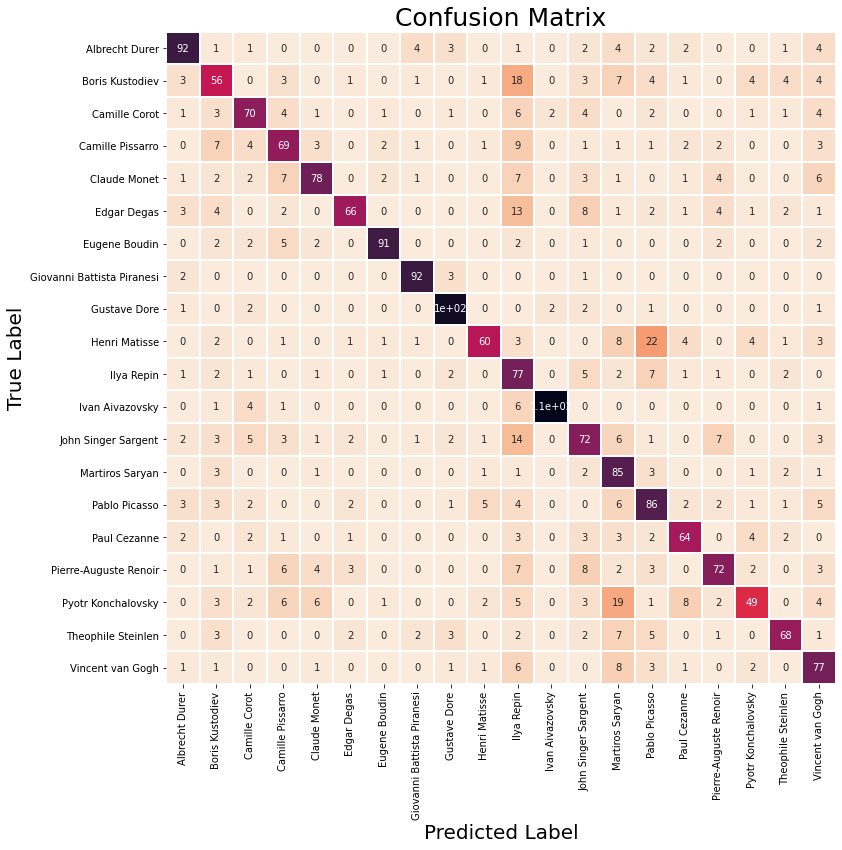

In [81]:
from sklearn.metrics import confusion_matrix

cfm=confusion_matrix(np.array(test_generator.classes), y_predict)     #Generate confusion matrix
plt.figure(figsize = (12,12))
sns.heatmap(cfm,
            annot=True,
            cbar=False,
            xticklabels=test_generator.class_indices,
            yticklabels=test_generator.class_indices,
            cmap="rocket_r",
            linewidths=1,
            
           )
plt.title('Confusion Matrix',size = 25,y=1.01)
plt.xlabel("Predicted Label", size = 20)
plt.ylabel("True Label", size = 20)
plt.show()

The largest overlap seems to occur between Matise and Picasso, following by Konchalovsky and Saryan and then Kustodiev and Repin. Getting more exact figures on misclassification by calculating precision and recall for each artist:

In [119]:
from sklearn.metrics import classification_report

report_initial = classification_report(np.array(test_generator.classes), y_predict, target_names=list(test_generator.class_indices))
print(report_initial)

                            precision    recall  f1-score   support

            Albrecht Durer       0.82      0.79      0.80       117
           Boris Kustodiev       0.58      0.51      0.54       110
             Camille Corot       0.71      0.69      0.70       101
          Camille Pissarro       0.64      0.65      0.64       106
              Claude Monet       0.80      0.68      0.73       115
               Edgar Degas       0.85      0.61      0.71       108
             Eugene Boudin       0.92      0.83      0.88       109
Giovanni Battista Piranesi       0.89      0.94      0.92        98
              Gustave Dore       0.87      0.92      0.89       113
             Henri Matisse       0.83      0.54      0.66       111
                Ilya Repin       0.42      0.75      0.54       103
           Ivan Aivazovsky       0.96      0.89      0.93       122
       John Singer Sargent       0.60      0.59      0.59       123
           Martiros Saryan       0.53      0.85

The best classified artists seem to be: Piranesi (sketch like art), Aivazovsky (many water dominated landscapes in realistic style), Dore (etchings) and Durer (distinctive early period often including sketch like art). On the other hand, Sargent and Kustodiev have both precision and recall as low values, meaning they are likely difficult to characterize uniquely. Picasso, Saryan and Repin stand out for having much higher recall than precision, meaning they are often being predicted as artists for others' work. This could point to a wider variety in their painting styles (Picasso especially seems to have widely differeing styles on inspection). Matisse seems to have the opposite problem where very few of his works are being classified as such, those that are have fairly high precision. This did indeed seem to be the case where independently downloaded works of Matisse were often predicted to be Picasso works (often using similar color and shape outlines). 

An example of a Matisse painting, donwloaded with some watermark like artifacts, which is correctly classified:

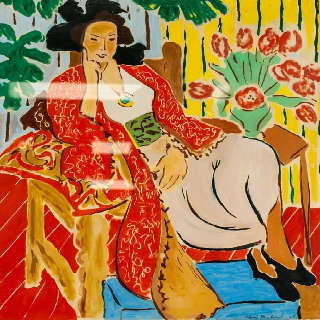

In [151]:
im= image.load_img('mat.jpg', target_size=(height,width)) #loading in image
im

In [ ]:
im2=image.img_to_array(im2)   #transform to number representations
testim=im2[np.newaxis,:,:]    #As model is trained on batches of images, convert to tensor with 1 entry in first dimension (batch of 1 image)

In [ ]:
predict = model5.predict(testim) #Make prediction
gueses=pd.DataFrame(predict.T, index=train_generator.class_indices, columns=['Prediction'])
gueses.sort_values(by='Prediction', ascending=False)                #Rank and display predictions

### Loading VGG trained model

Loading trained VGG model from above in order to further unfreeze and train layers and use as potential layers for artist style transfer:

In [65]:
!cp -r drive/MyDrive/Res_Artist_best/ .

In [77]:
from tensorflow.keras.models import load_model
model4=load_model('./Res_Artist_best')

In [74]:
model4.summary() #layer structure, used to find blocks and number of layers to unfreeze

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 320, 320, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 320, 320, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 320, 320, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 160, 160, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 160, 160, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 160, 160, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 80, 80, 128)       0     

In [68]:
len(model4.layers)

25

In [79]:
from tensorflow.keras.optimizers import Adam


model4_2=Sequential()
for layer in model4.layers[:-1]:  #After high layer unfreezing produced very low accuracy, reload model and strip last layer and reclassify on last softmax layer again
  model4_2.add(layer)



optimizer=Adam(0.001)

for layer in model4_2.layers:
    layer.trainable = False

#for layer in model4.layers[-3:]:             
#        if not isinstance(layer, layers.BatchNormalization):
#            layer.trainable = True

model4_2.add(Dense(20, activation='softmax'))

model4_2.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model4_2.fit(train_generator,
          epochs=5,
          callbacks=[early_stop],
          validation_data=validation_generator)

Epoch 1/5
195/195 [==============================] - 410s 2s/step - loss: 3.0057 - accuracy: 0.0519 - val_loss: 2.9897 - val_accuracy: 0.0578
Epoch 2/5
195/195 [==============================] - 405s 2s/step - loss: 2.9902 - accuracy: 0.0503 - val_loss: 2.9859 - val_accuracy: 0.0598
Epoch 3/5
195/195 [==============================] - 395s 2s/step - loss: 2.9842 - accuracy: 0.0513 - val_loss: 2.9816 - val_accuracy: 0.0611
Epoch 4/5
195/195 [==============================] - 389s 2s/step - loss: 2.9844 - accuracy: 0.0614 - val_loss: 2.9756 - val_accuracy: 0.0598
Epoch 5/5
195/195 [==============================] - 387s 2s/step - loss: 2.9781 - accuracy: 0.0569 - val_loss: 2.9725 - val_accuracy: 0.0797


As can be seen, even readding last dense layer, while keeping all previously trained weights the same, the validation accuracy is extremely bad, even the fresh pre-trained networks started much better in accuracy. This also occured when using previous literature models on almost identical dataset. Not clear what is causing this very large drop in accuracy and seems to defeat purpose of saving the model and using it in transferring styles.